In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import tensorflow_datasets as tfds

#tfds.list_builders()

In [2]:
train_data, info = tfds.load("cifar10", split="train[10%:]", with_info = True)
valid_data = tfds.load("cifar10", split="train[:10%]")
test_data = tfds.load("cifar10", split="test")

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [4]:
def parse_aug_fn(dataset):
    def zoom(x, sh = 224, sw = 224):
        x = tf.image.resize(x, (sh, sw))
        return x
    
    # 影像標準化
    x = tf.cast(dataset['image'], tf.float32) / 255.
    # 影像放大到224*224
    x = zoom(x)
    y = tf.one_hot(dataset['label'], 10)
    y = y
    
    return x, y

In [5]:
#模型儲存目錄
model_dir = 'cifar10/models'
if os.path.isdir(model_dir):
    print("已存在路徑「{}」".format(model_dir))
else:
    print("已建立路徑「{}」".format(model_dir))
    os.makedirs(model_dir)

已存在路徑「cifar10/models」


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 16
train_num = int(info.splits['train'].num_examples / 10) * 9
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data = train_data.batch(batch_size)
  
valid_data = valid_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.batch(batch_size)
 
test_data = test_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.batch(batch_size)

In [7]:
#回調函數
log_dir = os.path.join('cifar10','MobileNetV2-L2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq ='epoch')
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + "/Best-model-MobileNetV2-L2.h5", monitor='val_categorical_accuracy', mode='max')
# model_esp = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=300, mode='max')

In [8]:
model = tf.keras.models.load_model(model_dir + "/Best-model-MobileNetV2-L2.h5")

In [10]:
# input_shape = (224, 224)

# base_model = tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", pooling='avg', input_shape=input_shape+(3,))
# model=tf.keras.Sequential([
#     base_model,
#     layers.Dense(1024,activation='relu', kernel_regularizer = 'l2'),
#     layers.Dense(10,activation='softmax')
# ])

In [11]:
# for layer in model.layers:
#     layer.trainable = False
# # 或者使用如下方法凍結所有層
# # model.trainable = False 
# model.layers[-1].trainable = True
# model.layers[-2].trainable = True

# # print("顯示可以訓練的所有層")
# # for x in model.trainable_weights:
# #     print(x.name)

# # print("顯示不可訓練的所有層")
# # for x in model.non_trainable_weights:
# #     print(x.name)
 


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 3,579,978
Trainable params: 3,545,866
Non-trainable params: 34,112
_________________________________________________________________


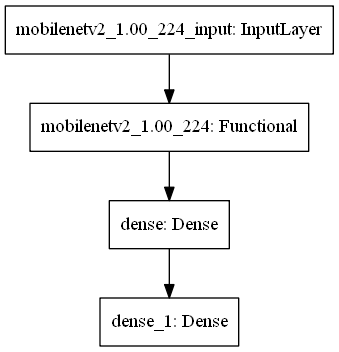

In [10]:
plot_model(model,to_file='model.png')

In [11]:
#優化器、損失函數，指標函數
model.compile(keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])

In [14]:
history = model.fit(train_data, epochs=120, initial_epoch=100, validation_data = valid_data, callbacks=[model_cbk, model_mckp])

Epoch 101/120
   2/2813 [..............................] - ETA: 8:12 - loss: 0.0098 - categorical_accuracy: 1.0000WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0370s vs `on_train_batch_end` time: 0.2430s). Check your callbacks.


2813/2813 [==============================] - 222s 79ms/step - loss: 0.0301 - categorical_accuracy: 0.9941 - val_loss: 0.4888 - val_categorical_accuracy: 0.9090
Epoch 102/120
2813/2813 [==============================] - 226s 80ms/step - loss: 0.0301 - categorical_accuracy: 0.9937 - val_loss: 0.4571 - val_categorical_accuracy: 0.9106
Epoch 103/120
2813/2813 [==============================] - 225s 80ms/step - loss: 0.0291 - categorical_accuracy: 0.9939 - val_loss: 0.3329 - val_categorical_accuracy: 0.9238
Epoch 104/120
2813/2813 [==============================] - 226s 80ms/step - loss: 0.0311 - categorical_accuracy: 0.9941 - val_loss: 0.3838 - val_categorical_accuracy: 0.9202
Epoch 105/120
2813/2813 [==============================] - 225s 80ms/step - loss: 0.0278 - categorical_accuracy: 0.9941 - val_loss: 0.4186 - val_categorical_accuracy: 0.9110
Epoch 106/120
2813/2813 [==============================] - 227s 81ms/step - loss: 0.0282 - categorical_accuracy: 0.9946 - val_loss: 0.3842 - val

In [15]:
# 訓練後的評估
print("train_data:")
model.evaluate(train_data)
print("valid_data:")
model.evaluate(valid_data)
print("test_data:")
model.evaluate(test_data)

train_data:
2813/2813 [==============================] - 62s 22ms/step - loss: 0.0231 - categorical_accuracy: 0.9954
valid_data:
313/313 [==============================] - 7s 22ms/step - loss: 0.3626 - categorical_accuracy: 0.9240
test_data:
625/625 [==============================] - 14s 22ms/step - loss: 0.3846 - categorical_accuracy: 0.9185


[0.38457027077674866, 0.9185000061988831]